# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.830654,True,5.688570
1,0.991928,False,1.107974
2,0.687503,True,6.511470
3,0.596286,False,0.756091
4,0.850370,True,6.052472
...,...,...,...
995,-0.561855,False,-1.037131
996,1.271949,True,5.821855
997,1.512748,True,6.696160
998,1.670951,True,6.439178


<AxesSubplot: xlabel='v0'>

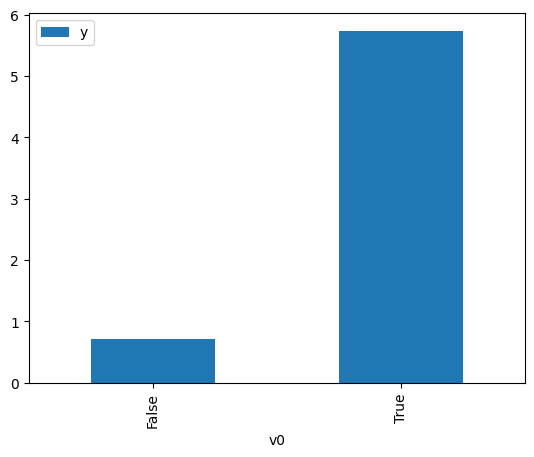

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

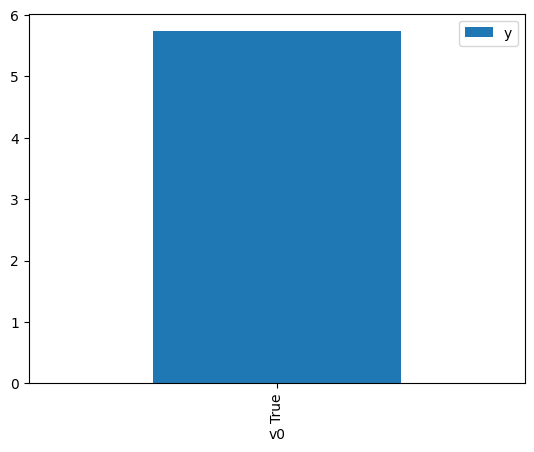

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.564681,False,0.578483,0.713363,1.401810
1,0.056139,False,-0.440915,0.502822,1.988776
2,0.667449,False,0.515287,0.294131,3.399848
3,0.391281,False,0.916131,0.383474,2.607739
4,-0.224882,False,-1.750362,0.603221,1.657768
...,...,...,...,...,...
995,1.845017,False,2.436110,0.070211,14.242690
996,0.426248,False,-1.083729,0.371556,2.691385
997,0.656429,False,0.984984,0.297460,3.361794
998,-0.154718,False,0.924406,0.578625,1.728235


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.990896,True,3.674175,0.177995,5.618144
1,3.158031,True,9.797357,0.988881,1.011244
2,0.631491,True,5.239682,0.694925,1.439003
3,0.858986,True,5.195719,0.760100,1.315617
4,1.033832,True,5.371950,0.803267,1.244917
...,...,...,...,...,...
995,-0.068911,True,6.359733,0.451981,2.212482
996,1.100182,True,4.560801,0.818033,1.222445
997,0.198735,True,4.889001,0.548731,1.822387
998,0.660516,True,5.172878,0.703777,1.420905


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                          1.189e+04
Date:                Mon, 03 Apr 2023   Prob (F-statistic):                        0.00
Time:                        14:22:15   Log-Likelihood:                         -1445.2
No. Observations:                1000   AIC:                                      2894.
Df Residuals:                     998   BIC:                                      2904.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0758      0.037     28.966      0.000       1.003       1.149
x2             4.9882      0.056     89.192      0.000       4.878       5.098
==============================================================================
Omnibus:                        0.397   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.290
Skew:                          -0.021   Prob(JB):                        0.865
Kurtosis:                       3.073   Cond. No.                         2.63
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""